# SEN163A - Fundamentals of Data Analytics
# Assignment 3 - Large-scale Internet Data Analysis
### Ir. Jacopo De Stefani - [J.deStefani@tudelft.nl](mailto:J.deStefani@tudelft.nl)
### Joao Pizani Flor, M.Sc. - [J.p.pizaniflor@tudelft.nl](mailto:J.p.pizaniflor@tudelft.nl)

### 25-03-2022
## Group 2
- Emmanuel M Boateng - '5617642'
- Joost Oortwijn - '4593472'
- Philip Busscher - ''4611993''
- Floris Kool - ''4975243''


# Introduction
short description of the assignment

# 1. Dataset description

Short description of the 4 datasets used

## 1.1 Opening the data

In [1]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import pandas as pd
import time
import pickle

In [4]:

#READING MAIN PAGE
#Get file
source_link = "https://jdestefani.github.io/SEN163A-TabularRazorArchives/"
response = requests.get(source_link)

#Read main file
main_page = BeautifulSoup(response.text)

for year_link in main_page.find_all('a', href=True):
    #READING YEAR PAGE & SAVING PKL FILE FOR EACH YEAR
    
    #Get file name of pkl file
    year_filename = year_link.get('href')
    year_filename = year_filename.removeprefix('./')
    year_filename = year_filename.removesuffix('.html')
    year_filename = "data/" + year_filename + ".pkl"
    
    #Clear lists of data for each year
    Data_Tuple = []
    
    #Get file  
    year_link = urljoin(source_link, year_link.get('href')) 
    response = requests.get(year_link)
    
    #Read year file
    year_page = BeautifulSoup(response.text)
     
    for month_link in year_page.find_all('a', href=True):
        #Get file
        month_link = urljoin(year_link, month_link.get('href'))
        response = requests.get(month_link)
        
        #Read month file
        month_page = BeautifulSoup(response.text)
        i = 0
        
        start  = time.time()
        
        for article_link in month_page.find_all('a', href=True):        
            #Get file
            article_link = urljoin(month_link, article_link.get('href')) 
            response = requests.get(article_link)
        
            #Read article file
            article_page = BeautifulSoup(response.text)
                       
            for div_element in article_page.find_all('div'):
                if div_element.get('class') == ['author']:
                    article_author = div_element.get_text()
                if div_element.get('class') == ['date']:
                    article_date = div_element.get_text()
                if div_element.get('class') == ['time']:
                    article_time = div_element.get_text()

            #Add data
            Data_Tuple.append((article_author, article_date, article_time))
            i += 1 
            #if i >= 10:
            #    break
        
        #Print after each month
        dur = round(time.time() - start,2)
        print('Read: ' + month_link)
        print('Added: ' + str(i) + ' articles')
        print('Duration: ' + str(dur) + ' seconds')
        
        #break

    #Save file after each year
    print()
    print("---")
    print("Saving: " + year_filename)
    df = pd.DataFrame(Data_Tuple)
    df.to_pickle(year_filename)
    print("Saved: " + str(len(df[0])) + " articles")
    print("---")
    print()
    
    #break
    

Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-1.html
Added: 3464 articles
Duration: 491.2 seconds
Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-2.html
Added: 2943 articles
Duration: 410.75 seconds
Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-3.html
Added: 3223 articles
Duration: 452.49 seconds
Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-4.html
Added: 3074 articles
Duration: 433.31 seconds
Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-5.html
Added: 3276 articles
Duration: 463.0 seconds
Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-6.html
Added: 3053 articles
Duration: 434.3 seconds
Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-7.html
Added: 3270 articles
Duration: 474.14 seconds
Read: https://jdestefani.github.io/SEN163A-TabularRazorArchives/2012-8.html
Added: 3370 articles
Duration: 481.03 seconds
Read: https://jdestefani.gi

More detailed description of data if needed (Can also be after opening each dataset)

## 1.2 Limitations in data

Evaluate if there are limitations in the provided datasets (AS and probe data set). If you find limitations, describe these and conjecture possible reasons, supported with data.

...

Some list of limitations in text

# 2 Analysis

Short description of what is going to be analyzed

## 2.1 Couple among employees (Question a)

Are there couples among the employees. If so, who? Are they still together?


## Check for all years

In [1]:
# Import all data combined
import pickle
import pandas as pd
merged = pickle.load(open("data/2012_2019.pkl", "rb"))
merged = merged.reset_index()
merged = merged.drop(['index'], axis=1) 

In [2]:
list_columns = ['Author','Date','Time']
merged.columns = list_columns

In [3]:
# Create a dataframe with all the publication dates per author
merged_groupby = merged.groupby(['Author'])['Date'].unique().apply(list).reset_index()
merged_groupby = merged_groupby.set_index('Author')

In [4]:
# Split the list with publication dates to a column
split_df = pd.DataFrame(merged_groupby['Date'].tolist())
split_df = split_df.set_index(merged_groupby.index)
split_df = split_df.astype(str)

In [5]:
# Create range of dates from the beginning of 2012 till the end of 20190
import datetime
start = datetime.datetime.strptime("2012-1-1", "%Y-%m-%d")
end = datetime.datetime.strptime("2019-12-31", "%Y-%m-%d")
date_generated = pd.date_range(start, end)

In [6]:
# Create new dataframe with only zero's 
import numpy as np
zero_df = np.zeros((len(split_df), len(date_generated)),str)
zero_df = pd.DataFrame(zero_df)
zero_df = zero_df.set_index(merged_groupby.index)
zero_df.columns = date_generated
zero_df.columns = zero_df.columns.strftime("%Y-%m-%d")

In [9]:
# Fill the new dataframe (with zero's) with ones in case an author has published on a specific date
list_index = list(split_df.index.values)

for i in list_index:
    for j in range(split_df.shape[1]):
        date = split_df.loc[i,j]
        if np.isnat(np.datetime64(date))==True:
            break
        else:
            zero_df.loc[i,date]=1

In [10]:
zero_df

,2012-01-01,2012-01-02,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-07,2012-01-08,2012-01-09,2012-01-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
Author,,,,,,,,,,,,,,,,,,,,,
Adriene Wilde,,,,,,,,,,,...,,,,,,,,,,
Andreas Jost,,1,1,1,1,1,,,1,1,...,,1,1,1,1,1,,,1,1
Angela Compos,,,,,,,,,,,...,,,1,1,1,1,,,1,1
Anisha Mathes,,1,,,,1,1,,,1,...,,1,1,1,1,1,,,1,1
Annie Lapham,,1,1,1,,1,,,1,1,...,,1,1,1,,1,,,1,1
Augusta Beltrami,,,,,,,,,,,...,,,,,,,,,,
Aurea Durrance,,1,1,1,1,1,,,1,1,...,,1,1,1,1,1,,,1,1
Bebe Riva,,1,1,1,1,1,,,1,1,...,,1,1,1,1,1,,,1,1
Bridgette Marko,,1,1,1,1,1,,,1,1,...,,1,1,1,1,1,,,1,1


## 2.2 Children (Question b)
Did any of the employees have a child? If so, who?

In [2]:
#Code for question b


Description of results

## 2.3 Holidays (Question c)
If you would be looking to work for Tabularazor Inc., how many holidays can you expect to get per
year?


In [ ]:
#Code for question c
#extend dataframe by dates
data['date'] = pd.to_datetime(data['datetime'].dt.date)
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data

#find max time employees don't post anything
for names in employees:
    df_f =  data.loc[data['name']==names]
    print(names, df_f['date'].diff().max())

#Compile all data and check 

Description of results

# 3 Conclusion

Add code if needed

In [ ]:
#Alternative by Emmanuel

data["datetime"] = data.iloc[:, 1] +" " +data.iloc[:, 2]

    #format to date time 
data['datetime'] = pd.to_datetime(data['datetime'],format= '%Y-%m-%d %H:%M') 
data = data.drop(data.columns[[1, 2]], axis=1)
data.columns = ['name', 'datetime']

#floor to hours
#data['datetime'] = data['datetime'].dt.floor('h')

#create multiple features to enhance analysis for Machine Learning
#data['year'] = data['datetime'].dt.year
#data['month'] = data['datetime'].dt.month
#data['day'] = data['datetime'].dt.day
#data['hour'] = data['datetime'].dt.hour
data['time'] = data['datetime'].dt.time


print(data.dtypes)
data.head()
employees = data['name'].unique().tolist()

In [ ]:
# group the names based on the dates and time published
df = data.set_index('datetime').groupby([pd.Grouper(freq='H'), 'name']).count()
df.rename(columns = {'time':'n'}, inplace = True)
df = df.reset_index()  # make sure indexes pair with number of rows
df


In [ ]:
publication_tsp = data['datetime'].unique()

l= []
# iterate to get equal publication times
for timestamp in publication_tsp:
    df_f =  df.loc[df['datetime']==timestamp]
    if df_f.shape[0] !=0:
        l.append(df_f.groupby('n')['name'].apply(list).reset_index(name='lst'))



In [ ]:
from collections import Counter
from itertools import combinations

new_list = []
# create a new list of list 
for entry in l:
    lst  = entry['lst'].values.tolist()
    for items in lst:
        new_list.append(items)

# count likelihood of being a copule based on how often they occure together
d  = Counter()
for sub in new_list:
    if len(new_list) < 2:
        continue
    for comb in combinations(sub,2):
        d[comb] += 1
#create a dataframe for couple pairings
couples_df = pd.DataFrame(d.most_common(), columns = ['likely_couple', 'occurences'])

In [ ]:
couples_df.head()

# 4 Appendix

## 4.1 Plotting the data

In [6]:
# Create dictionary with month as key and per key a list of list of publications dates per author
import collections
import re
d = {}
for i in list(data['month'].unique()):
    list_of_authors = []
    subset = data.loc[data['month'] == i]
    for j in subset.groupby(['Author'])['Date'].unique().tolist():
        list_data = []
        for k in j:
            day_number = k[-5:]
            day_number = int(re.sub(r'-','',day_number))
            list_data.append(day_number) #This list contains all the publications dates of a single author for a single month
        list_of_authors.append(list_data) #This list contains all the publication dates of all authors for a single month
    d[i]=list_of_authors #Add publication dates of all authors for a single month to the dictionary

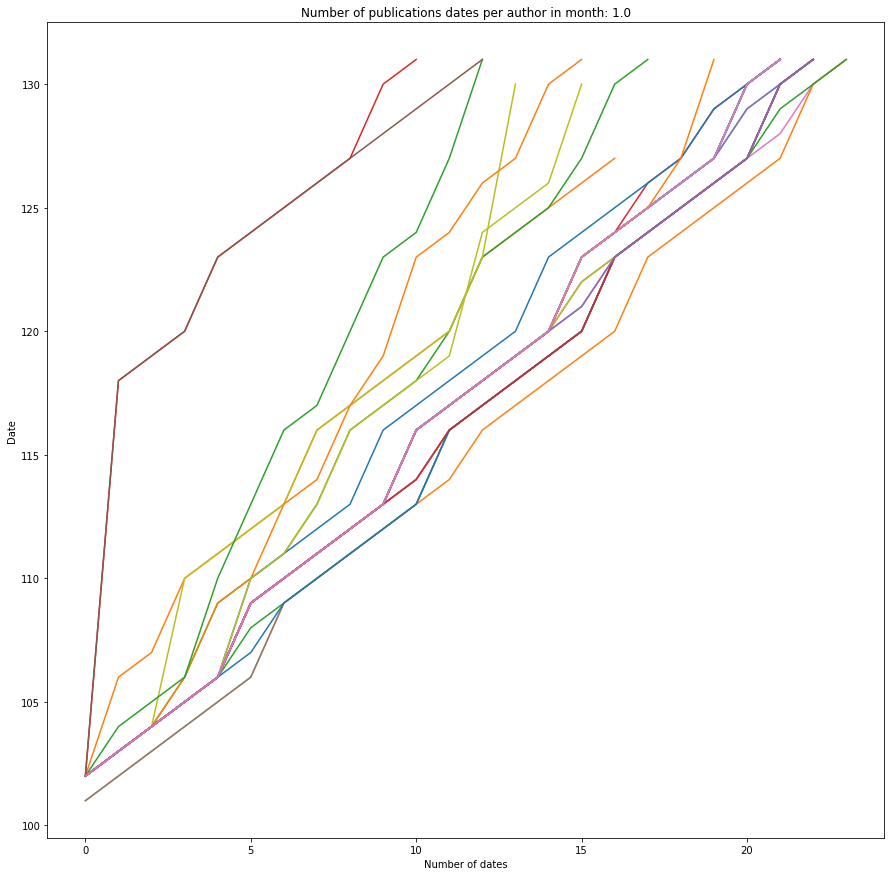

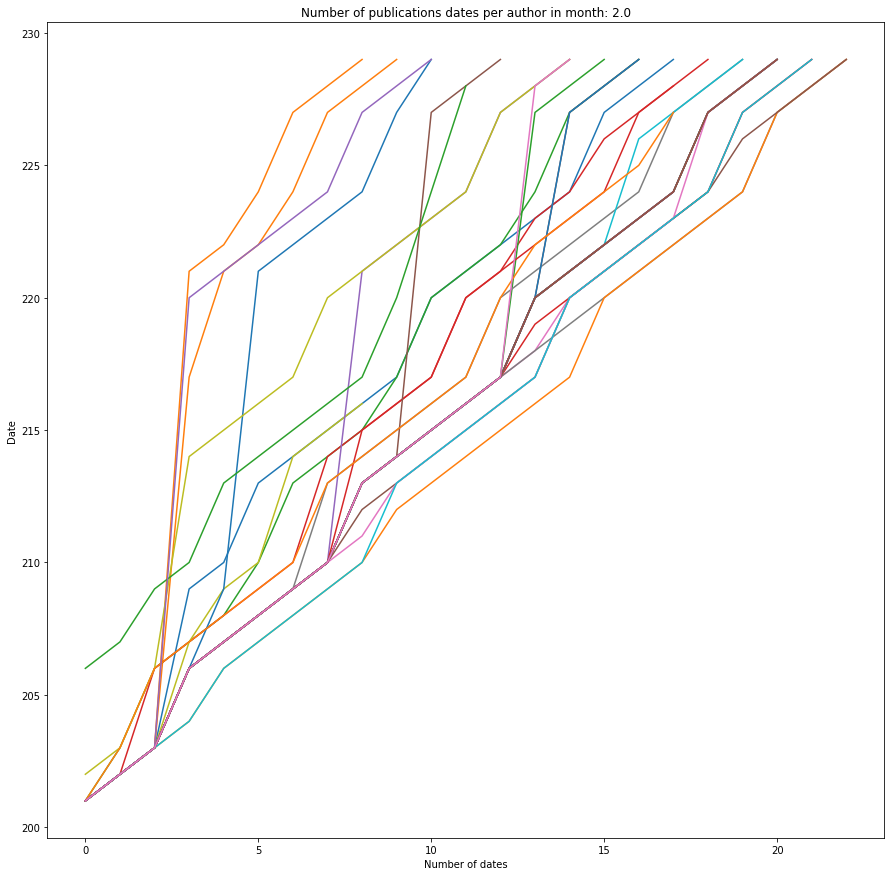

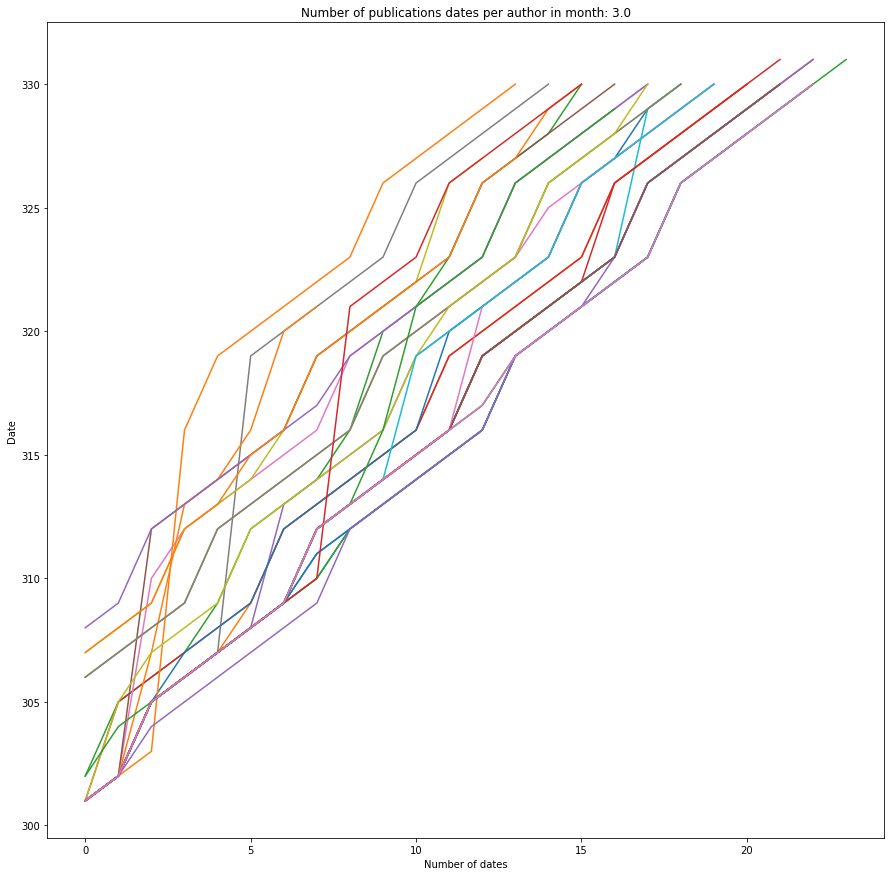

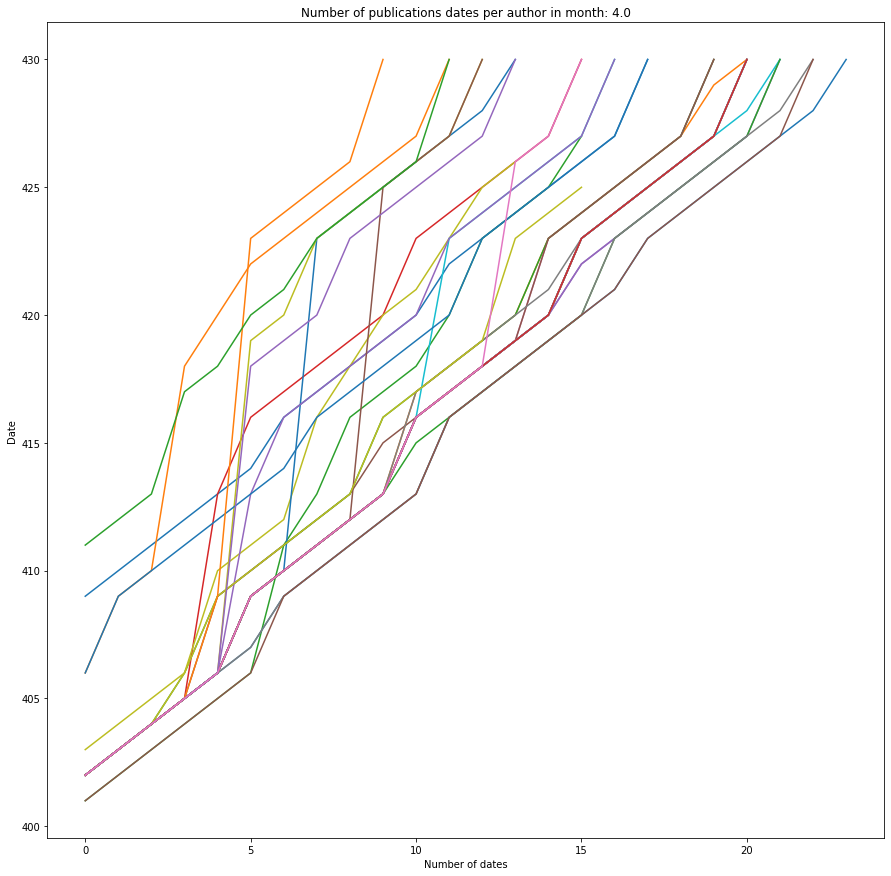

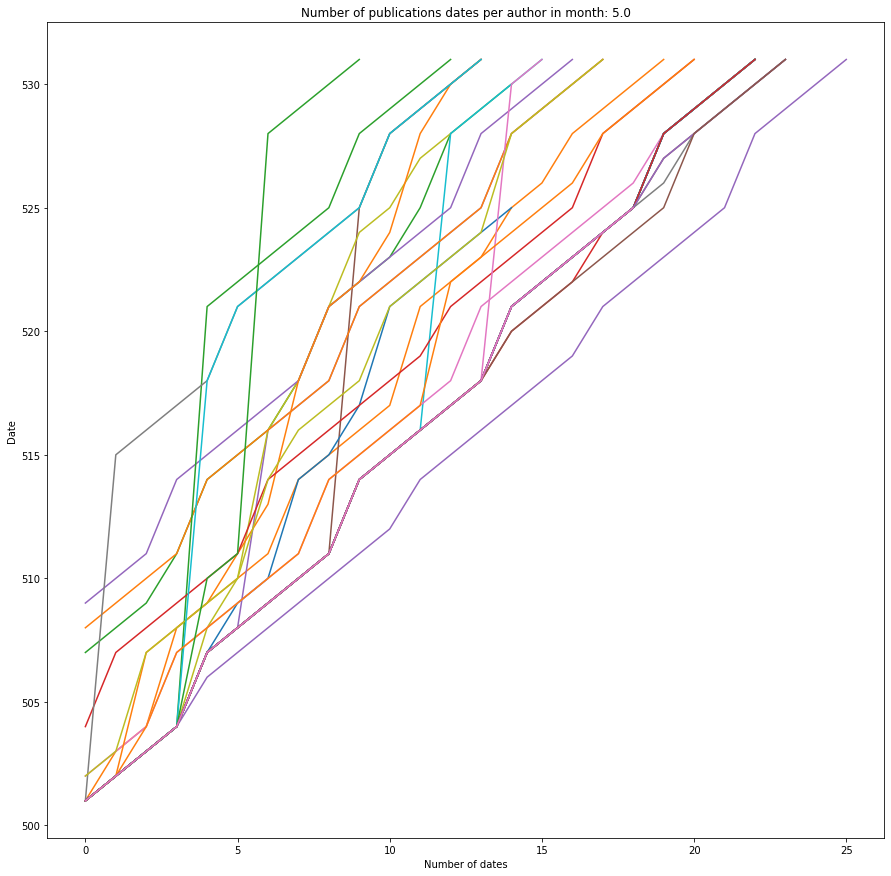

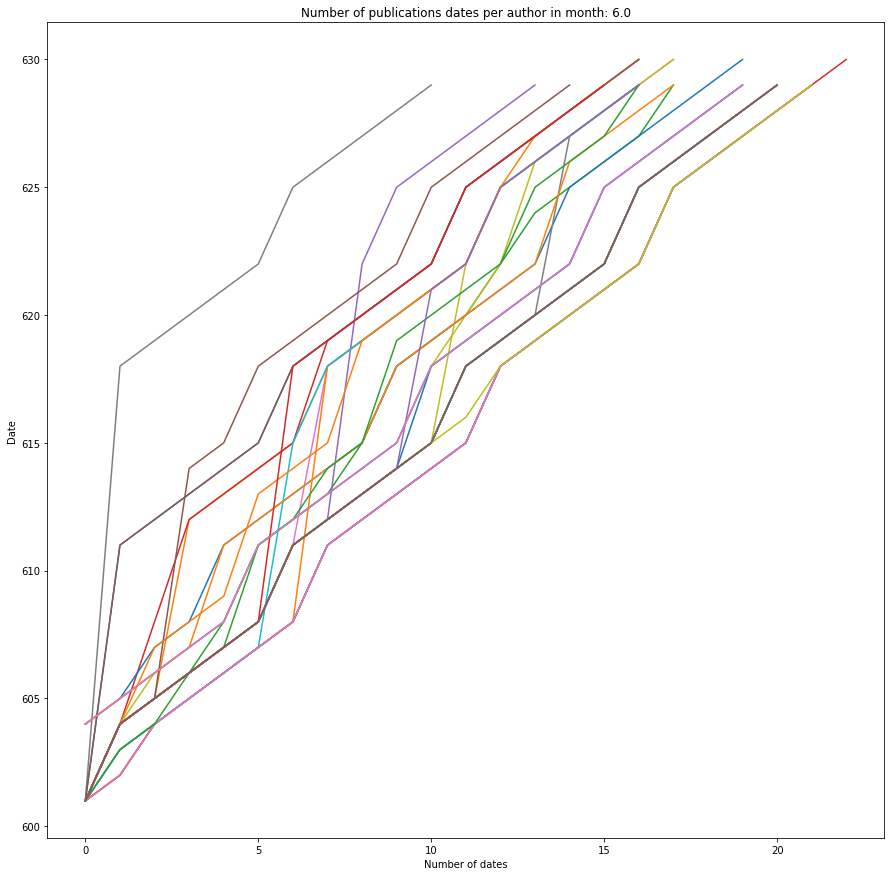

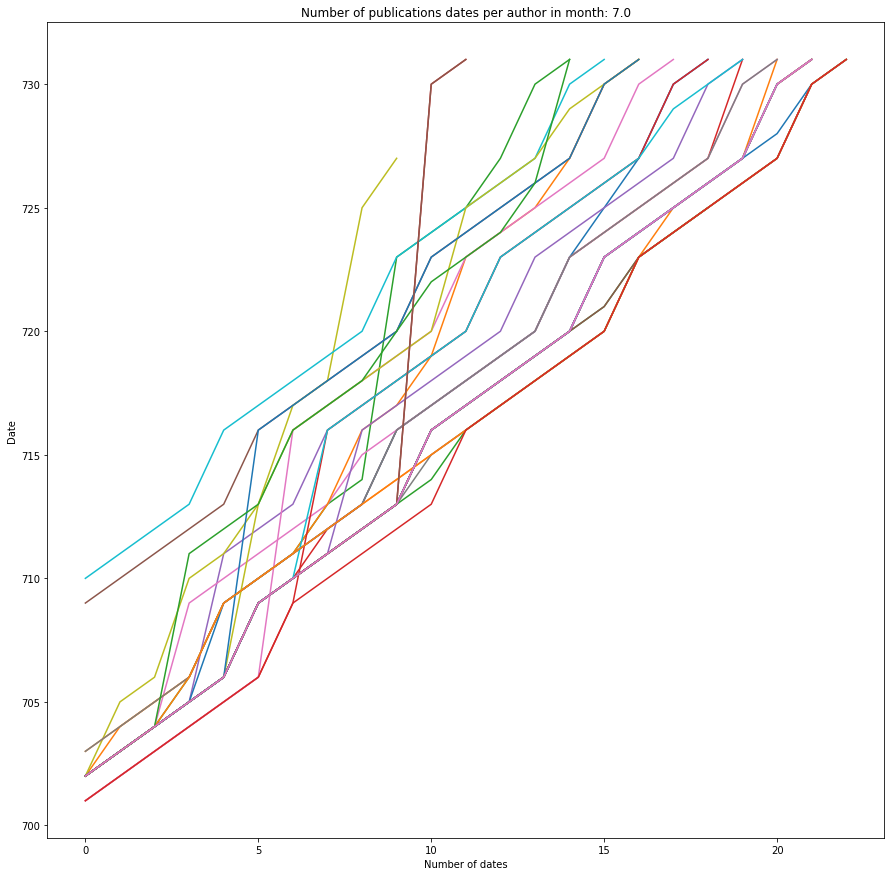

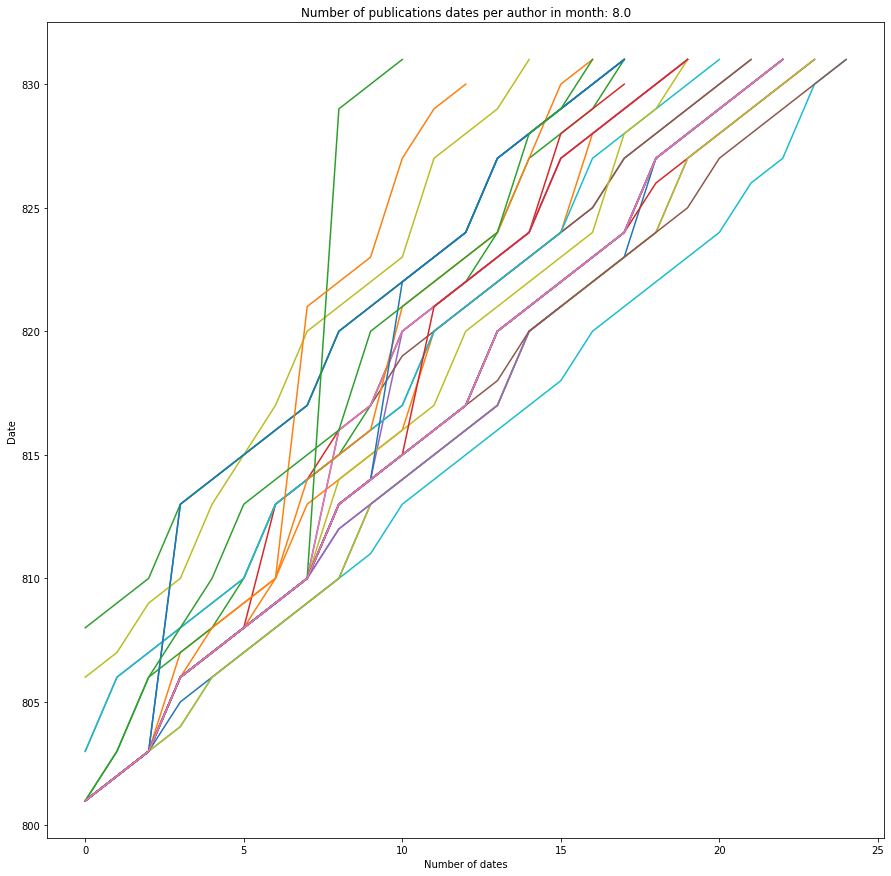

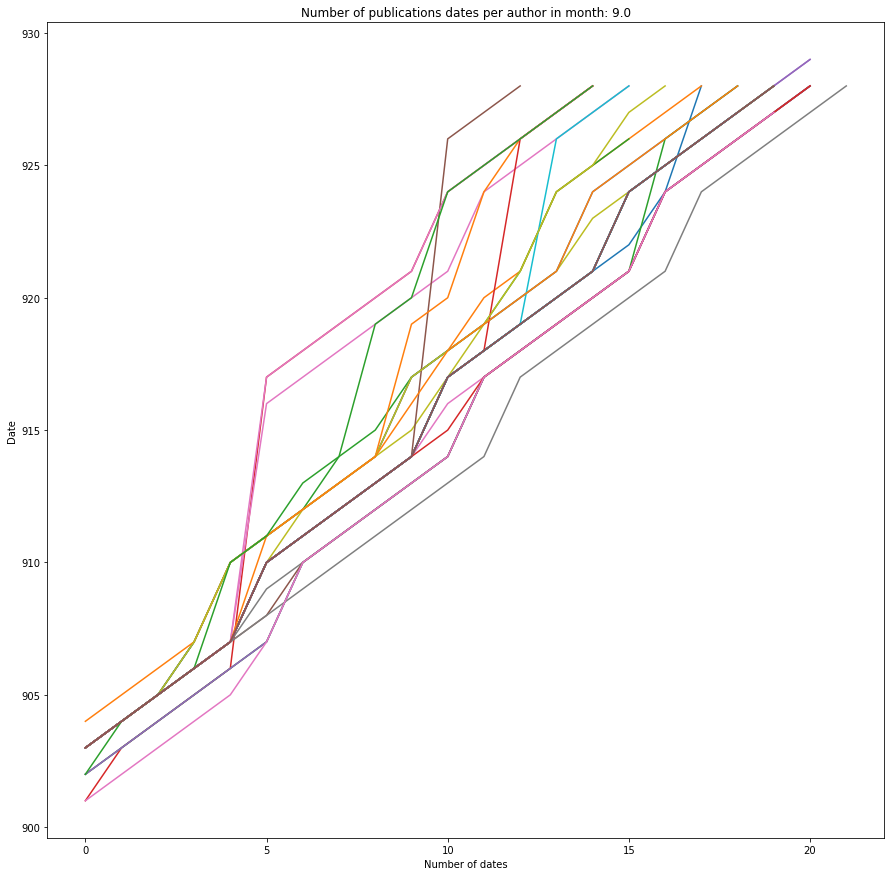

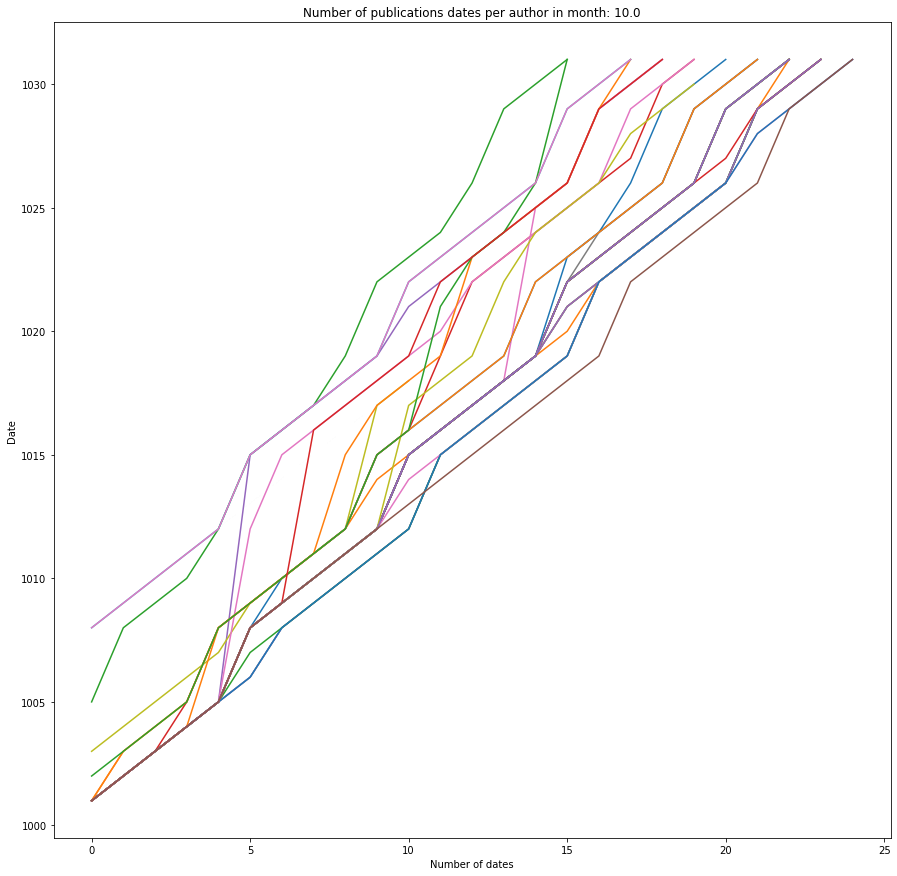

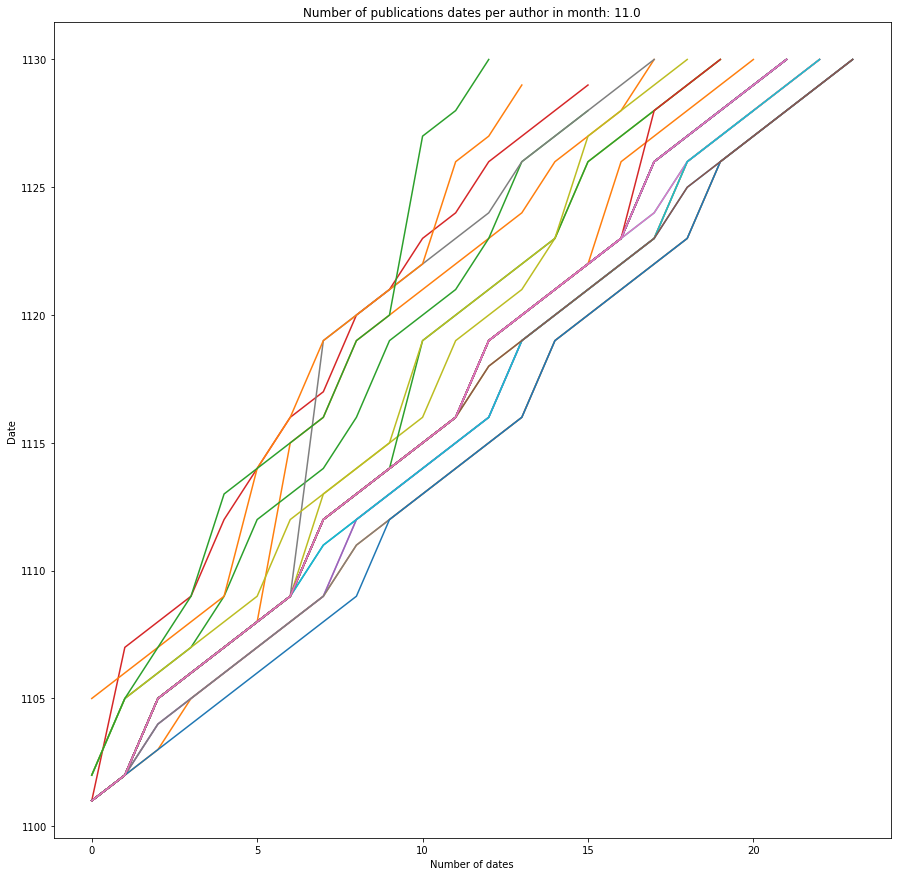

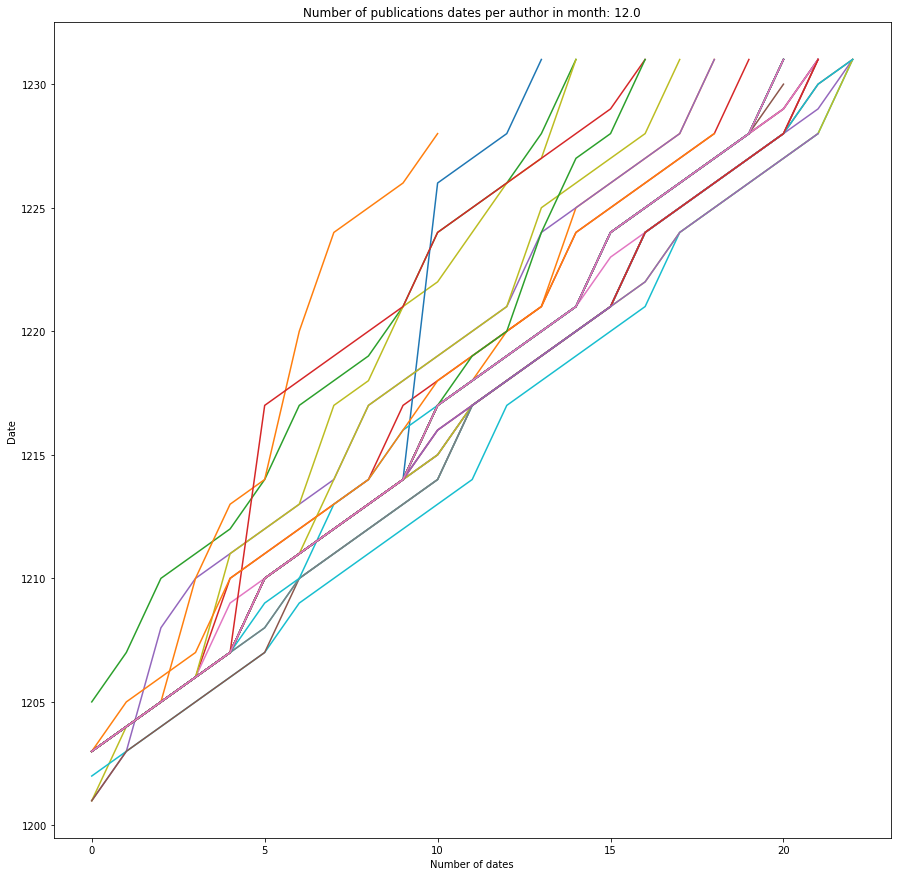

In [7]:
# Plot publications per author (each line represents one author) per month
import matplotlib.pyplot as plt 
for key in d:
    output = d[key]
    plt.figure(figsize=(15,15))
    for dates in output:
        plt.plot(dates)
        plt.xlabel('Number of dates')
        plt.ylabel('Date')
        title = ("Number of publications dates per author in month: "+ str(key))
        plt.title(title)
plt.show()

## 4.2 Old code (Joost)

In [1]:
#Find potential couple by checking if they both publish less in specific months
import re

def couple_find(df,year,output_dict):
    for i in Author_combinations:
        author1 = i[0]
        author2 = i[1]
        for j in list(df['Month'].unique()):
            subset = df.loc[(df['Author'].isin(i))]
            subset = subset.loc[subset['Month'] == j]
            subset = subset.reset_index()
            list_data1 = []
            list_data2 = []
            for k in range(len(subset)):
                if k == (len(subset)-1):
                    if (((len(list(set(list_data1))))<14) and ((len(list(set(list_data2))))<14)):
                        if i in output_dict:
                            output_dict[i].append((j,year))
                        else:
                            couple_list = [(j,year)]
                            output_dict[i]=(couple_list)
                        break
                elif subset.loc[k,'Author'] == author1:
                        day_number1 = subset.loc[k,'Date']
                        list_data1.append(day_number1)
                elif subset.loc[k,'Author'] == author2:
                        day_number2 = subset.loc[k,'Date']
                        list_data2.append(day_number2)
                else:
                    break
    return output_dict

## Check for one year

In [37]:
# Import only one year
import pickle
data = pickle.load(open("data/2019.pkl", "rb"))

In [38]:
# Add column names
list_columns = ['Author','Date','Time']
data.columns = list_columns

In [39]:
# Add column with the month number to do the analysis per month
for i in range(len(data)):
    month = int(data.loc[i,'Date'][-5:-3])
    data.loc[i,'Month'] = month

In [40]:
#Find all potential combinations of author couples
from itertools import combinations
Author_combinations = []
Author_list = data['Author'].unique().tolist()
Author_combinations += list(combinations(Author_list,2))

In [6]:
dict_2019 = {}
couple_find(data,2019,dict_2019)

{('Tasia Dube', 'Lorrine Paek'): [(4.0, 2012)],
 ('Tasia Dube', 'Tora Echevarria'): [(4.0, 2012)],
 ('Tasia Dube', 'Marthe Hale'): [(8.0, 2012)],
 ('Tasia Dube', 'Narcisa Core'): [(4.0, 2012)],
 ('Tasia Dube', 'Leatrice Heer'): [(4.0, 2012)],
 ('Lorrine Paek', 'Veronique Blakemore'): [(2.0, 2012)],
 ('Lorrine Paek', 'Jarvis Pratts'): [(2.0, 2012)],
 ('Lorrine Paek', 'Tora Echevarria'): [(2.0, 2012), (4.0, 2012)],
 ('Lorrine Paek', 'Hassan Toner'): [(2.0, 2012), (3.0, 2012)],
 ('Lorrine Paek', 'Anisha Mathes'): [(2.0, 2012)],
 ('Lorrine Paek', 'Narcisa Core'): [(2.0, 2012), (4.0, 2012)],
 ('Lorrine Paek', 'Leatrice Heer'): [(4.0, 2012)],
 ('Veronique Blakemore', 'Jarvis Pratts'): [(2.0, 2012)],
 ('Veronique Blakemore', 'Tora Echevarria'): [(2.0, 2012)],
 ('Veronique Blakemore', 'Hassan Toner'): [(2.0, 2012)],
 ('Veronique Blakemore', 'Anisha Mathes'): [(2.0, 2012)],
 ('Veronique Blakemore', 'Narcisa Core'): [(2.0, 2012)],
 ('Jarvis Pratts', 'Tora Echevarria'): [(2.0, 2012)],
 ('Jarvis P

In [41]:
couple_dict_cleaned = {}
for key in dict_2019:
    check_list = dict_2019[key]
    if len(check_list) != 1:
        couple_dict_cleaned[key]=check_list
couple_dict_cleaned

{('Lorrine Paek', 'Tora Echevarria'): [(2.0, 2012), (4.0, 2012)],
 ('Lorrine Paek', 'Hassan Toner'): [(2.0, 2012), (3.0, 2012)],
 ('Lorrine Paek', 'Narcisa Core'): [(2.0, 2012), (4.0, 2012)],
 ('Tora Echevarria', 'Hassan Toner'): [(2.0, 2012), (5.0, 2012)],
 ('Tora Echevarria', 'Narcisa Core'): [(2.0, 2012), (4.0, 2012)],
 ('Vonk Billips', 'Julieta Knapp'): [(1.0, 2012), (7.0, 2012)]}

In [43]:
#Check if potential couples are real couples by hand

import re

### FILL IN MONTH NUMBER OF INTEREST ###
month_interest = 12
### ###

for i in list(data['Month'].unique()):
    if i == month_interest:
        subset = data.loc[data['Month'] == month_interest]
        for j in subset.groupby(['Author'])['Date'].unique().tolist():
            list_data = []
            for k in j:
                if not list_data:
                    index_list = subset.groupby(['Author'])['Date'].unique().apply(list).tolist()
                    index = index_list.index(list(j))
                    Author_list.sort()
                    author = Author_list[index]
                    list_data.append(author)
                else:
                    day_number = k[-5:]
                    day_number = int(re.sub(r'-','',day_number))
                    list_data.append(day_number)
            if len(list_data[1:])<=12:
                #print('potential leave by : ',author)
                print(list_data)

['Anisha Mathes', 202, 203, 217, 221, 222, 224, 227, 228, 229]
['Hassan Toner', 202, 203, 207, 209, 210, 214, 215, 216]
['Jarvis Pratts', 202, 203, 206, 209, 221, 222, 223, 224, 227, 229]
['Lorrine Paek', 202, 203, 221, 222, 224, 227, 228, 229]
['Narcisa Core', 202, 203, 206, 207, 208, 209, 210, 213, 214, 227, 228, 229]
['Tora Echevarria', 207, 209, 210, 213, 214, 215, 216, 217, 220, 224, 228]
['Veronique Blakemore', 202, 203, 220, 221, 222, 223, 224, 227, 228, 229]
